# Assignment 1 
Name : Adarsh Shah \
SR : 19473

In [11]:
from importlib.resources import path
import spacy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

model_paths = {
    #'word2vec':'/tmp/en_word2vec_300d', #To get word2vec txt format
    'glove':'/tmp/en_glove_840B_300d',
    'glove_6B':'/tmp/en_glove_6B_300d',
    'fasttext':'/tmp/en_fasttext_300d',
    'tok2vec':'en_core_web_lg'
}

In [2]:
model = 'fasttext' # Specify pretrained embedding here from ['word2vec', 'glove', 'fasttext', 'tok2vec']

In [3]:
positive_samples = open('/home/adarsh/DLNLP/datasets/Assignement1/Train.pos','r').readlines()
negative_samples = open('/home/adarsh/DLNLP/datasets/Assignement1/Train.neg','r').readlines()
nlp = spacy.load('en_core_web_lg')

In [4]:
print(f'Vocab Size : {len(nlp.vocab.vectors.keys())}')

Vocab Size : 684830


In [5]:
nlp('apple').vector[:10]

array([-0.36391 ,  0.43771 , -0.20447 , -0.22889 , -0.14227 ,  0.27396 ,
       -0.011435, -0.18578 ,  0.37361 ,  0.75339 ], dtype=float32)

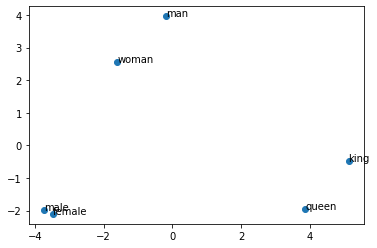

In [6]:
text = ['king','queen','man','woman','male','female']
docs = list(nlp.pipe(text))
vectors = [ doc.vector for doc in docs ]
vectors = PCA(2).fit_transform(vectors)
plt.scatter(vectors[:,0],vectors[:,1])
for txt, vector in zip(text,vectors):
    plt.annotate(txt, (vector[0], vector[1]))
plt.show()

In [4]:
pos_docs, neg_docs = list(nlp.pipe(positive_samples, n_process=10)), list(nlp.pipe(negative_samples, n_process=10))
pos_vectors, neg_vectors = np.array([ np.mean([ token.vector for token in doc ], axis=0) for doc in pos_docs ]), np.array([ np.mean([ token.vector for token in doc ], axis=0) for doc in neg_docs ])

In [8]:
X = np.concatenate([pos_vectors,neg_vectors])
tsne = TSNE()
X = tsne.fit_transform(X)
pos_tsne, neg_tsne = X[:5000], X[5000:]

/home/adarsh/anaconda3/envs/adarsh/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/adarsh/anaconda3/envs/adarsh/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


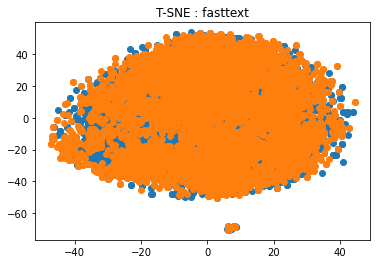

In [9]:
plt.title('''T-SNE : {}'''.format(model))
plt.scatter(pos_tsne[:,0], pos_tsne[:,1])
plt.scatter(neg_tsne[:,0], neg_tsne[:,1])
plt.show()

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
class SentimentDataset(Dataset):

    def __init__(self, nlp, samples, device):
        self.nlp = nlp
        self.samples = torch.from_numpy(samples).to(device)
        self.Y = torch.ones(size=(len(self.samples),2)).to(device)
        self.Y[:5000,0] = 0
        self.Y[5000:,1] = 0
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx], self.Y[idx]

dataset = SentimentDataset(nlp, np.concatenate([pos_vectors, neg_vectors]), device)
training_data, valid_data = torch.utils.data.random_split(dataset, [8000, 2000]) # 80 - 20 split

In [7]:
class SentimentClassifier(nn.Module):
    def __init__(self, layer1=50):
        super(SentimentClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=300, out_features=layer1, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(in_features=layer1, out_features=2, bias=True))
        self.layers.append(nn.Softmax(1))

    def forward(self, x):
        h = x
        [ h := layer(h) for layer in self.layers ]
        return h

In [8]:
def accuracy(model, data):
    pred = model(dataset.samples[data.indices]).argmax(dim=1)
    Y = dataset.Y[data.indices].argmax(dim=1)
    return ((pred == Y).long().sum()/len(data)).to('cpu').numpy()

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer, training_data):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [15]:
from tqdm import tqdm
data_loader = DataLoader(training_data, batch_size=8000, shuffle=False)

valid_accuracy = []
training_accuracy = []
epochs = []
loss = nn.CrossEntropyLoss()
for layer1 in tqdm(range(1, 1001, 10)):
    classifier = SentimentClassifier(layer1).to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    prev = accuracy(classifier, valid_data)
    for ep in range(100):
        train_loop(data_loader, classifier, loss, optimizer, training_data)
    training_accuracy.append(accuracy(classifier, training_data))
    valid_accuracy.append(accuracy(classifier, valid_data))

100%|██████████| 100/100 [12:23<00:00,  7.43s/it]


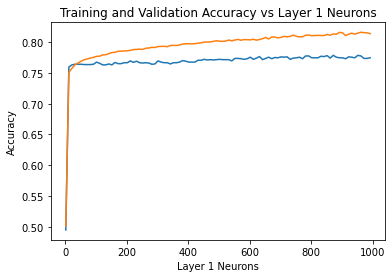

In [16]:
plt.title('Training and Validation Accuracy vs Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
plt.plot(range(1, 1001, 10), valid_accuracy)
plt.plot(range(1, 1001, 10), training_accuracy)
plt.show()

In [39]:
np.argmax(valid_accuracy), 1-np.max(valid_accuracy)

(87, 0.2214999794960022)

In [18]:
np.argmax(training_accuracy), np.max(training_accuracy)

(96, 0.81600004)

In [25]:
data_loader = DataLoader(training_data, batch_size=8000, shuffle=False)
classifier = SentimentClassifier(900).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
prev = accuracy(classifier, valid_data)
for ep in tqdm(range(10000)):
    if ep%1000==0:
        print(train_loop(data_loader, classifier, loss, optimizer, training_data))
    else:
        train_loop(data_loader, classifier, loss, optimizer, training_data)

  0%|          | 2/10000 [00:00<08:39, 19.26it/s]

tensor(0.6929, device='cuda:0', grad_fn=<DivBackward1>)


 10%|█         | 1003/10000 [01:16<10:31, 14.24it/s]

tensor(0.3588, device='cuda:0', grad_fn=<DivBackward1>)


 20%|██        | 2003/10000 [02:31<09:26, 14.12it/s]

tensor(0.3486, device='cuda:0', grad_fn=<DivBackward1>)


 30%|███       | 3003/10000 [03:47<08:13, 14.17it/s]

tensor(0.3461, device='cuda:0', grad_fn=<DivBackward1>)


 40%|████      | 4003/10000 [05:01<06:56, 14.41it/s]

tensor(0.3454, device='cuda:0', grad_fn=<DivBackward1>)


 50%|█████     | 5003/10000 [06:17<05:47, 14.39it/s]

tensor(0.3445, device='cuda:0', grad_fn=<DivBackward1>)


 60%|██████    | 6003/10000 [07:32<04:36, 14.45it/s]

tensor(0.3443, device='cuda:0', grad_fn=<DivBackward1>)


 70%|███████   | 7003/10000 [08:48<03:35, 13.90it/s]

tensor(0.3440, device='cuda:0', grad_fn=<DivBackward1>)


 80%|████████  | 8004/10000 [10:04<02:33, 12.99it/s]

tensor(0.3440, device='cuda:0', grad_fn=<DivBackward1>)


 90%|█████████ | 9003/10000 [11:21<01:09, 14.38it/s]

tensor(0.3438, device='cuda:0', grad_fn=<DivBackward1>)


100%|██████████| 10000/10000 [12:37<00:00, 13.21it/s]


In [26]:
testfile = open('/home/adarsh/DLNLP/datasets/Assignement1/TestData.txt','r')
lines = testfile.readlines()
docs = list(nlp.pipe(lines, n_process=10))
vectors = np.array([ doc.vector for doc in docs ])
vectors = torch.Tensor(vectors).to('cuda')
y = np.zeros(len(vectors))
y[:len(vectors)//2] = 1
y = torch.Tensor(y).to('cuda')

In [27]:
pred = classifier(vectors)
pred = pred.argmax(dim=1)

In [28]:
1-(pred == y).int().sum()/len(vectors)

tensor(0.2372, device='cuda:0')